In [1]:
import pandas as pd 
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import langdetect as ld
import multiprocessing as mp
import string
import re 

%config InlineBackend.figure_format = 'retina'
mpl.rcParams['font.size']=16
plt.style.use('fivethirtyeight')

nltk.download('vader_lexicon')

df_reviews = pd.read_csv('data/reviews.csv.gz')
df_listings = pd.read_csv('data/listings.csv')
df_geojson = gpd.read_file('data/neighbourhoods.geojson')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Derevirn\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
cols = ['listing_id', 'date', 'comments', 'neighbourhood']

df = pd.merge(df_reviews, df_listings, left_on='listing_id',
        right_on='id')

df = df[cols]

df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

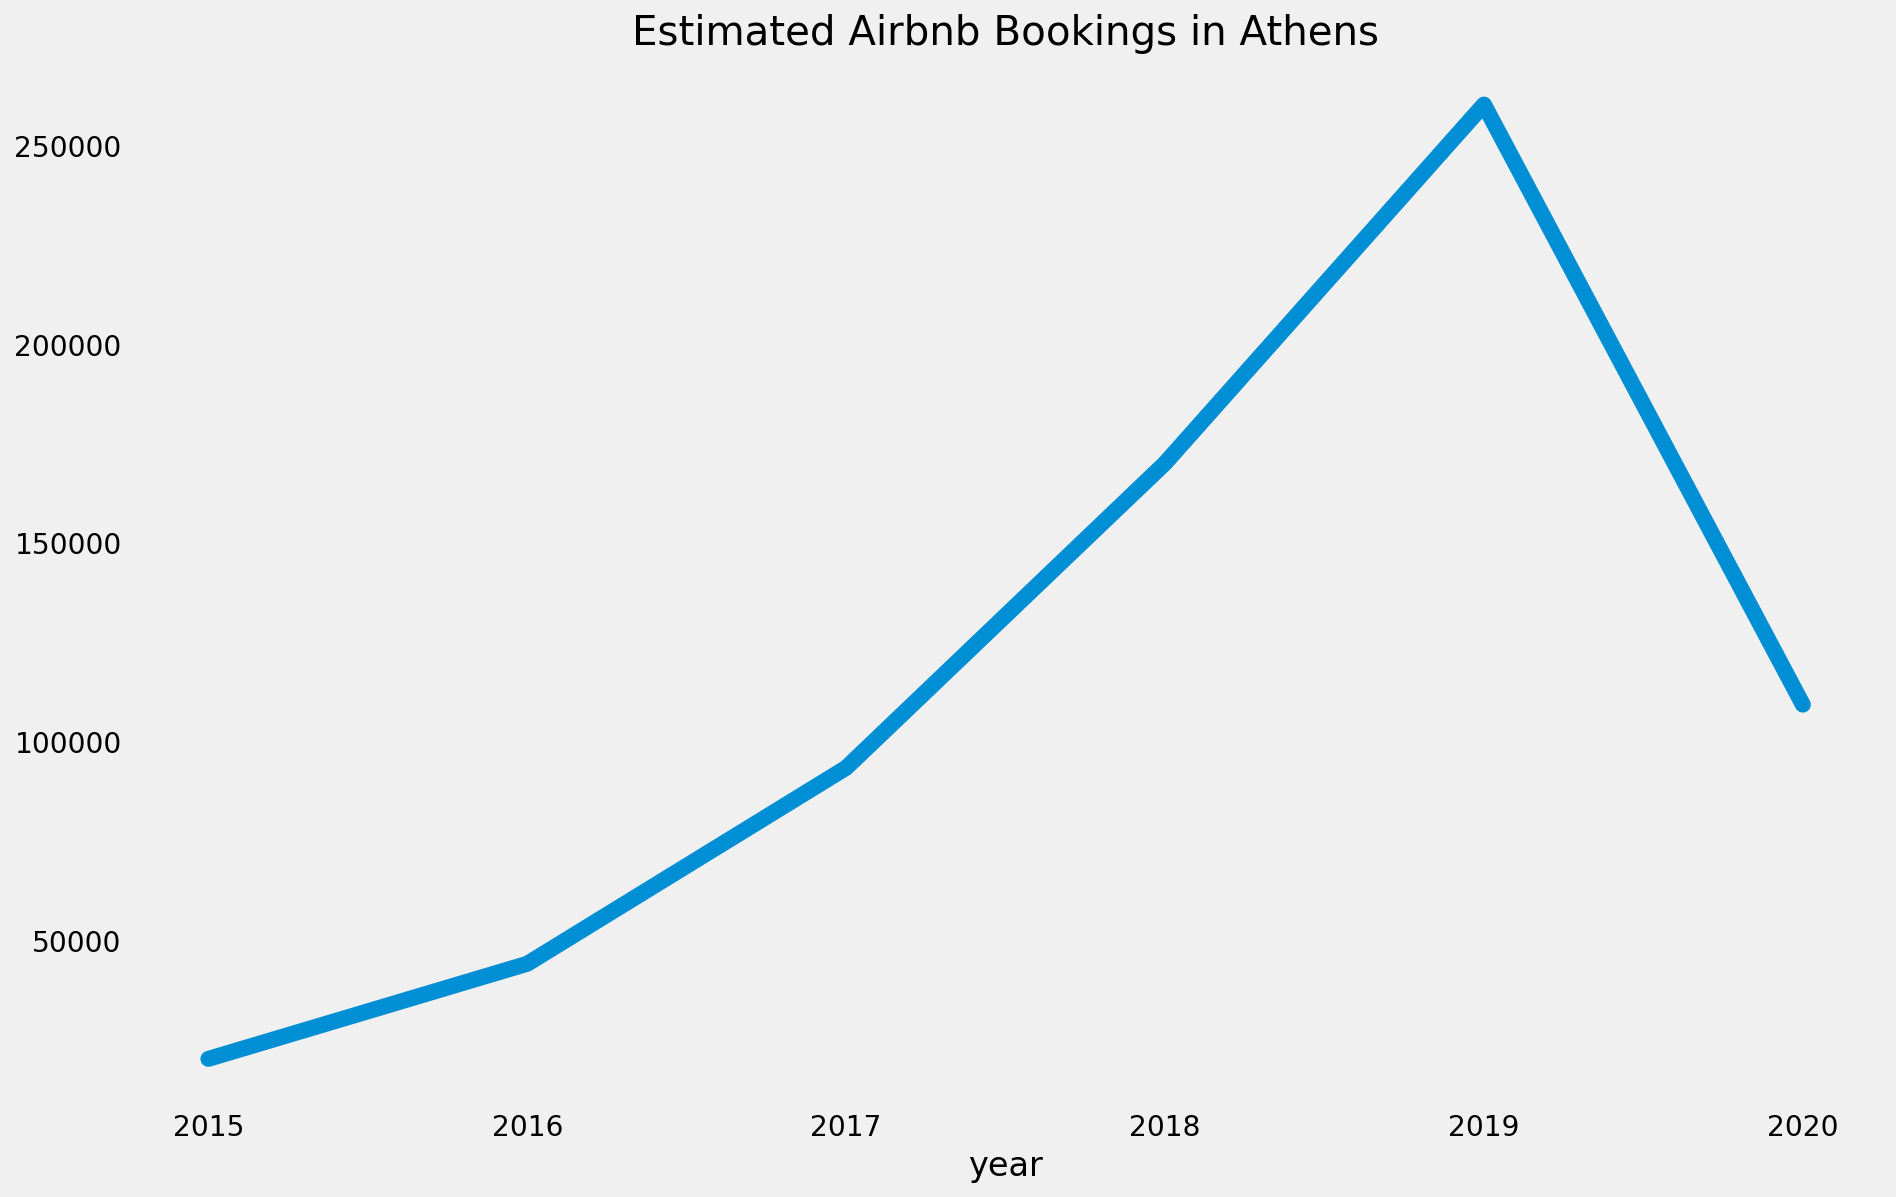

In [3]:
query = 'year>2014 and year<2021'
df_years = df.query(query).groupby(['year']).size() * 2
df_years.plot(kind='line', figsize=(14,9), lw=8, solid_capstyle='round',
              title='Estimated Airbnb Bookings in Athens')

plt.grid(False)
plt.box(False)
plt.savefig('bookings_years.png', dpi=150,
            transparent=True, bbox_inches = 'tight')

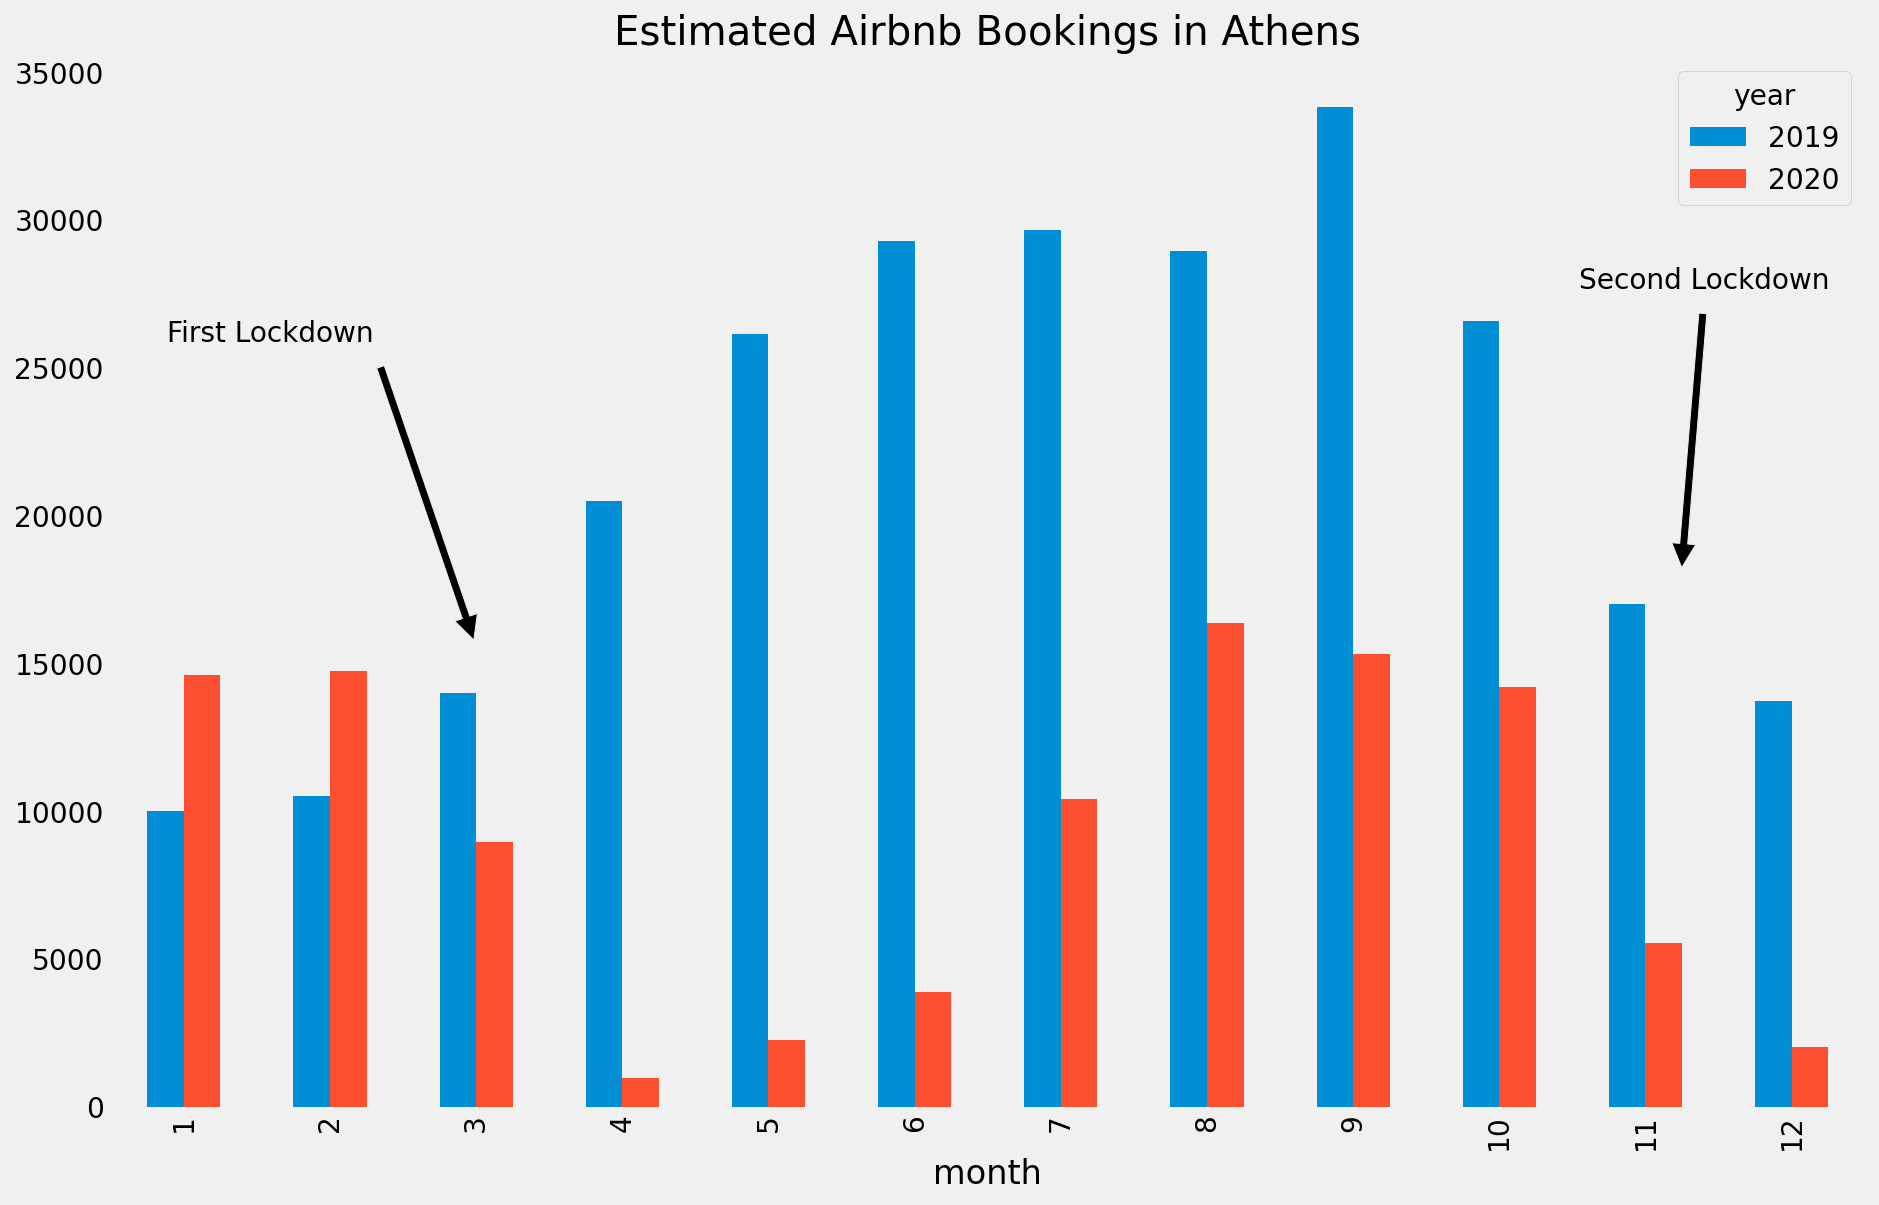

In [4]:
query = 'year>2018 and year<2021'
df_months = df.query(query).groupby(['month','year']).size().unstack() * 2
df_months.plot(kind='bar', figsize=(14,9),
               title='Estimated Airbnb Bookings in Athens')

plt.annotate('First Lockdown', xy=(0.21, 0.43),  xycoords='axes fraction',
            xytext=(0.15, 0.75), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top')

plt.annotate('Second Lockdown', xy=(0.895, 0.5),  xycoords='axes fraction',
            xytext=(0.98, 0.8), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top')

plt.grid(False)
plt.box(False)
plt.savefig('bookings_months.png', dpi=150,
            transparent=True, bbox_inches = 'tight')

In [5]:
df_months[2020]/ df_months[2019]

month
1     1.458300
2     1.402857
3     0.640949
4     0.047489
5     0.086391
6     0.133115
7     0.350850
8     0.565605
9     0.452841
10    0.534105
11    0.325417
12    0.146498
dtype: float64

In [6]:
query = 'year>2018 and year<2021'
df_neighbourhoods = df.query(query).groupby(['neighbourhood','year']).size() * 2
df_neighbourhoods = df_neighbourhoods.unstack().reset_index()

columns={2019:'bookings_2019',
         2020:'bookings_2020'}

df_neighbourhoods.rename(columns=columns, inplace=True)
df_athens = df_geojson.merge(df_neighbourhoods, on='neighbourhood')

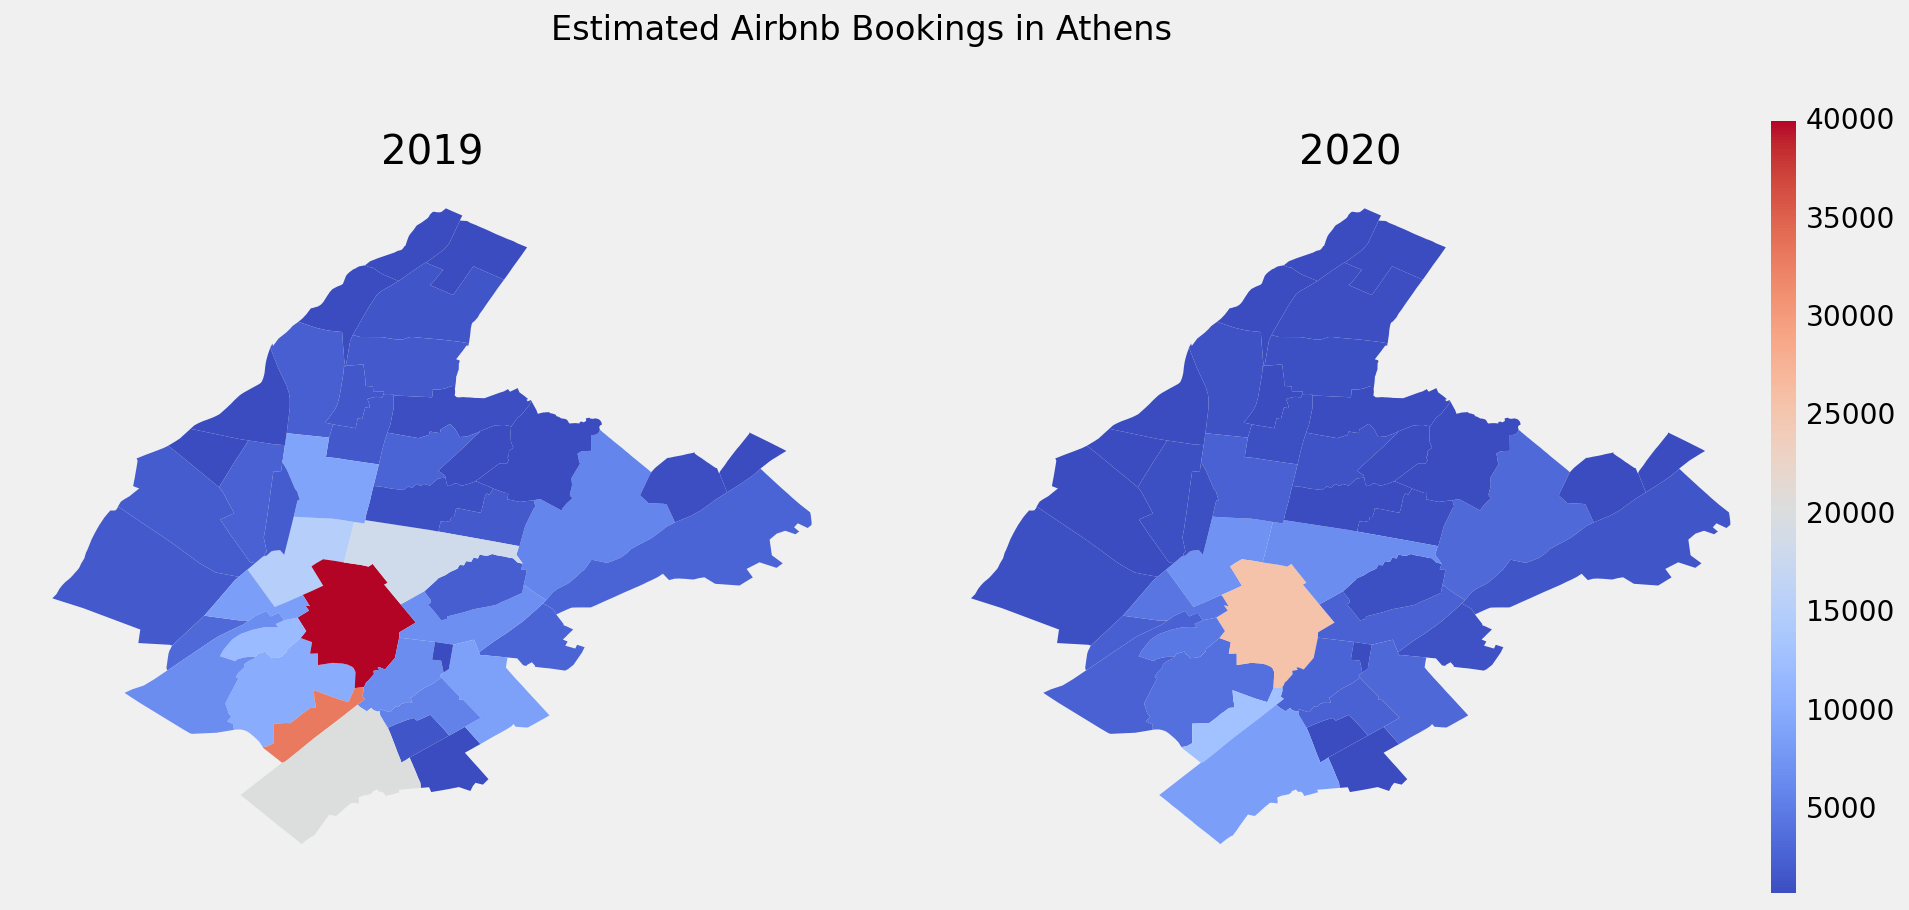

In [7]:
cmap = 'coolwarm'
vmin, vmax = 500, 40000

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 9))
cbar_ax = fig.add_axes([0.95, 0.3, 0.015, 0.6])

df_athens.plot(column='bookings_2019', vmin=vmin, vmax=vmax, 
               cmap=cmap, ax=ax1)
df_athens.plot(column='bookings_2020', vmin=vmin, vmax=vmax,
               cmap=cmap, ax=ax2)

plt.subplots_adjust(wspace=0.1, hspace=0.1, top=1.1)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical')

ax1.axis('off')
ax2.axis('off')

fig.suptitle("Estimated Airbnb Bookings in Athens")
ax1.set_title("2019")
ax2.set_title("2020")

plt.savefig('bookings_neighbourhoods.png', dpi=150,
            transparent=True, bbox_inches = 'tight')

In [8]:
def clean_str(string):
    string_ = re.sub('[^a-zA-Z ]+', '', string)
    return string_

pool = mp.Pool(8)


df_19_20 = df.query("year > 2018 and year < 2021")
df_19_20 = df_19_20.dropna()

df_19_20['comments'] = df_19_20['comments'].apply(clean_str)
df_19_20['comments'] = df_19_20['comments'].str.strip()
idx = df_19_20.query("comments == '' ").index
df_19_20.drop(idx, inplace=True)

df_19_20['lang'] = pool.map(ld.detect, df_19_20['comments'])
pool.close()
pool.join()

idx = df_19_20.query("lang != 'en' ").index
df_19_20.drop(idx, inplace=True)

In [9]:
vds = SentimentIntensityAnalyzer()
pool = mp.Pool(8)

#Analyzing the sentiment of Airbnb reviews with VADER.
#This process is quite CPU intensive,
#and will take 1-2 minutes on a fairly modern computer.


%time df_19_20['sentiment'] = pool.map(vds.polarity_scores, df_19_20['comments'])
pool.close()
pool.join()

#Extracting the compound sentiment score from the output of VADER
df_19_20['sentiment'] = df_19_20['sentiment'].apply(lambda x: dict(x)['compound'])

Wall time: 12.2 s


In [10]:
df_sentiment = df_19_20.groupby(['neighbourhood','year'])['sentiment'].mean()
df_sentiment = df_sentiment.unstack().reset_index()

columns={2019:'sentiment_2019',
         2020:'sentiment_2020'}

df_sentiment.rename(columns=columns, inplace=True)

df_athens = df_athens.merge(df_sentiment, on='neighbourhood')

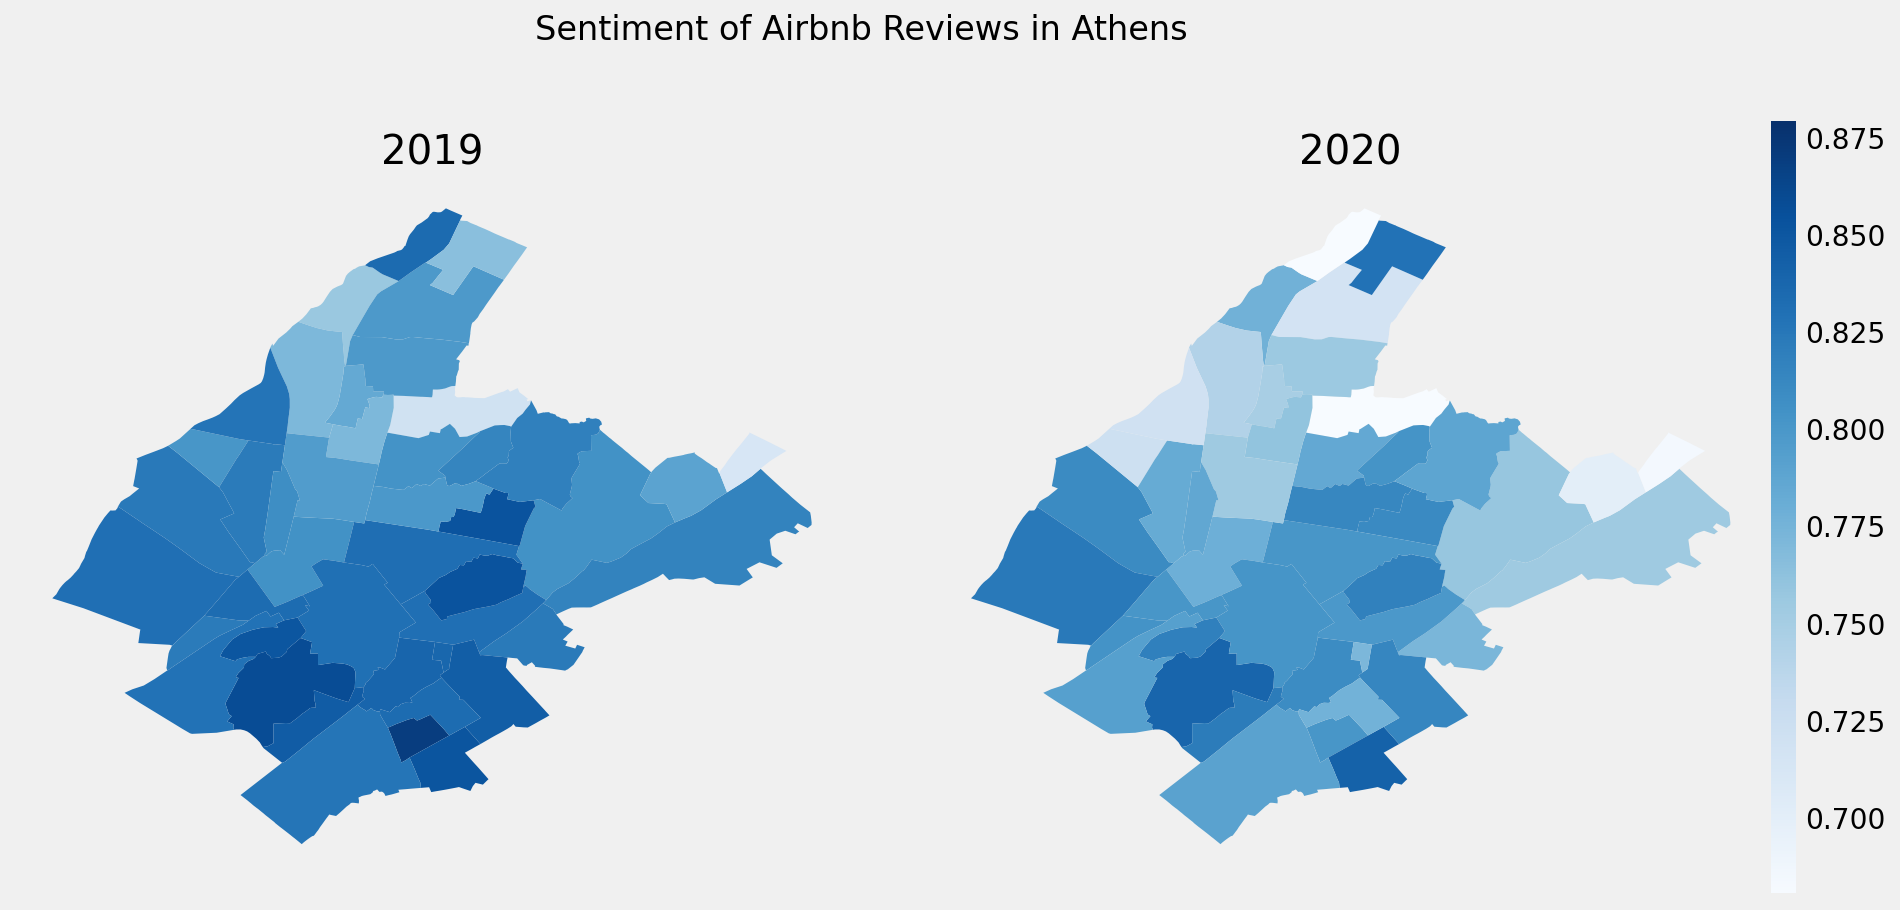

In [11]:
cmap = 'Blues'
vmin, vmax = 0.68, 0.88

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 9))
cbar_ax = fig.add_axes([0.95, 0.3, 0.015, 0.6])

df_athens.plot(column='sentiment_2019', vmin=vmin, vmax=vmax, 
               cmap=cmap, ax=ax1)
df_athens.plot(column='sentiment_2020', vmin=vmin, vmax=vmax,
               cmap=cmap, ax=ax2)

plt.subplots_adjust(wspace=0.1, hspace=0.1, top=1.1)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical')

ax1.axis('off')
ax2.axis('off')

fig.suptitle("Sentiment of Airbnb Reviews in Athens")
ax1.set_title("2019")
ax2.set_title("2020")

plt.savefig('sentiment_neighbourhoods', dpi=150,
            transparent=True, bbox_inches = 'tight')

In [12]:
df_athens.sort_values(by='sentiment_2020', ascending=False)

,neighbourhood,neighbourhood_group,geometry,bookings_2019,bookings_2020,sentiment_2019,sentiment_2020
12,ΓΟΥΒΑ,None,"MULTIPOLYGON (((23.74755 37.95728, 23.74697 37...",630,224,0.851361,0.841200
5,ΑΚΡΟΠΟΛΗ,None,"MULTIPOLYGON (((23.72432 37.97559, 23.72405 37...",10056,3800,0.858707,0.838851
40,ΡΙΖΟΥΠΟΛΗ,None,"MULTIPOLYGON (((23.74952 38.02935, 23.75043 38...",122,56,0.765002,0.828925
9,ΒΟΤΑΝΙΚΟΣ,None,"MULTIPOLYGON (((23.69862 37.99356, 23.70137 37...",1784,878,0.831518,0.824400
23,ΚΟΥΚΑΚΙ-ΜΑΚΡΥΓΙΑΝΝΗ,None,"MULTIPOLYGON (((23.73134 37.96807, 23.73071 37...",33028,12724,0.846190,0.821824
17,ΘΗΣΕΙΟ,None,"MULTIPOLYGON (((23.72354 37.97706, 23.72281 37...",11764,4548,0.850958,0.818549
25,ΛΥΚΑΒΗΤΤΟΣ,None,"MULTIPOLYGON (((23.75227 37.98599, 23.75217 37...",2108,812,0.853345,0.817684
30,ΠΑΓΚΡΑΤΙ,None,"MULTIPOLYGON (((23.74581 37.97592, 23.74644 37...",8634,3050,0.844316,0.813973
32,ΠΕΔΙΟ ΑΡΕΩΣ,None,"MULTIPOLYGON (((23.74597 37.99691, 23.74614 37...",844,472,0.799405,0.813389
11,ΓΚΥΖΗ,None,"MULTIPOLYGON (((23.75370 37.99441, 23.75394 37...",1764,724,0.852964,0.810478
